In [1]:
import metatensor.models

In [2]:
from metatensor.models.utils.llpr import LLPRModel

In [3]:
import torch
import rascaline.torch

model = torch.jit.load("model.pt")

In [4]:
from metatensor.models.utils.data import read_targets, read_systems

qm9_systems = read_systems("qm9_reduced_100.xyz", dtype=torch.float64)
ethanol_system = read_systems("ethanol_reduced_100.xyz", dtype=torch.float64)[0]

target_config = {
    'energy': {
        'quantity': 'energy',
        'read_from': 'ethanol_reduced_100.xyz',
        'file_format': '.xyz',
        'key': 'energy',
        'unit': 'kcal/mol',
        'forces': False,
        'stress': False,
        'virial': False,
    },
}

targets = read_targets(target_config, dtype=torch.float64)

In [5]:
from metatensor.models.utils.data import Dataset, collate_fn
from metatensor.models.utils.neighbor_lists import get_system_with_neighbor_lists

requested_neighbor_lists = model.requested_neighbor_lists()
qm9_systems = [get_system_with_neighbor_lists(system, requested_neighbor_lists) for system in qm9_systems]
ethanol_system = get_system_with_neighbor_lists(ethanol_system, requested_neighbor_lists)

dataset = Dataset({"system": qm9_systems, **targets})

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn,
)

In [7]:
llpr_model = LLPRModel(model)
llpr_model.compute_covariance(dataloader)
llpr_model.compute_inverse_covariance()
llpr_model.calibrate(dataloader)

In [9]:
from metatensor.torch.atomistic import ModelOutput

outputs = llpr_model([ethanol_system], outputs={"mtm::aux::energy_uncertainty": ModelOutput(per_atom=True)})
lpr = outputs["mtm::aux::energy_uncertainty"].block().values.cpu().detach().numpy()

In [26]:
# import ase.io

# structures = ase.io.read("ethanol_reduced_100.xyz", ":")
# for structure, lpr in zip(structures, lprs):
#     structure.arrays["lpr"] = lpr

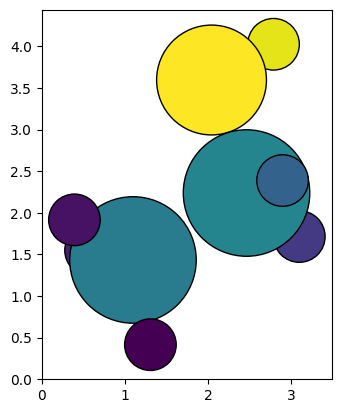

In [12]:
import ase.io
from ase.visualize.plot import plot_atoms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

structure = ase.io.read("ethanol_reduced_100.xyz")

norm = LogNorm(vmin=min(lpr), vmax=max(lpr))
colormap = plt.get_cmap('viridis')
colors = colormap(norm(lpr))
plot_atoms(structure, colors=colors, rotation="180x,0y,0z")
plt.show()
